<a href="https://colab.research.google.com/github/althemore/2026_SNUIPS_AI_Workshop/blob/main/RAG_Workshop_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2026 SNUIPS_AI_Workshop_Session_1
### An Introduction to RAG Through Chatbot Experiment Design with Streamlit (발표자: 안선우)


이 노트북에서는 RAG(Retrieval-Augmented Generation)의 핵심 개념을 실습합니다.

사용문서: OECD 한국 디지털 정부 리뷰 (2025)

## 왜 OECD 문서를 사용하나요?
- **2025년 1월 발표**: LLM이 사전 학습하지 않은 최신 정보
- **구체적인 정책 권고와 통계**: 정확한 정답 비교 가능

## 실습 구성
1. **환경설정** - API Key 설정
2. **데이터 로드** - OECD 문서 불러오기
3. **Chunking** - 청크 만들어 보기
4. **Context Aware Chunking** - 이전 내용 요약으로 문맥 보존
5. **Embedding** - 임베딩 모델 및 유사도 분석
6. **Query 비교** - 파라미터 설정에 따른 및 답변 품질 비교
7. **TF-IDF vs BM25 비교** - 키워드 검색 방법 비교
8. **Semantic Search vs Keyword Search** - 검색 방식 비교
9. **RAG vs 순수 LLM** - RAG의 가치 확인

## 시작 전 본인의 드라이브에 '사본만들기'

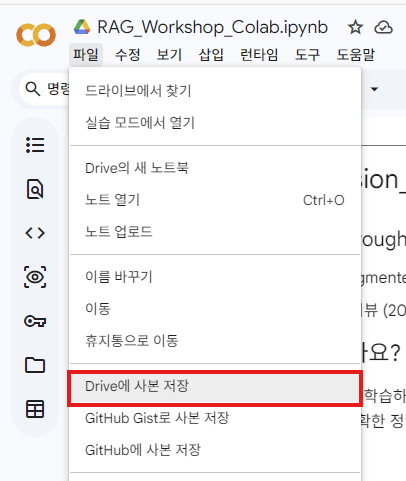

---
## 1. 환경 설정

In [ ]:
# GITHUB에 있는 Colab_data_OECD.txt 파일 다운 후 업로드 하기
# https://github.com/yoonlee78/2026_SNUIPS_AI_Workshop/tree/main/Hands_on_1

from google.colab import files

uploaded = files.upload()

Saving oecd.txt to oecd.txt


##### **API Key 설정하기**
화면 우측의 열쇠 모양에서 API Key 작성 후 노트북 엑세스 허용 하기!
- API Key 이름은 GOOGLE_API_KEY / OPENAI_API_KEY 으로 통일

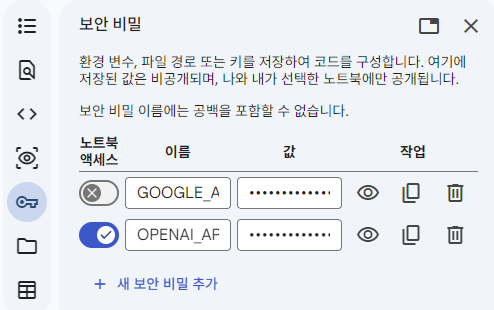

In [ ]:
# API 키 설정
import os
from google.colab import userdata

# Colab Secrets에서 API 키 가져오기 (권장)
# 또는 직접 입력: os.environ["OPENAI_API_KEY"] = "your-key-here"
try:
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
    print("GOOGLE_API_KEY 설정됨")
except:
    print("GOOGLE_API_KEY 없음")

try:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    print("OPENAI_API_KEY 설정됨")
except:
    print("OPENAI_API_KEY 없음")

GOOGLE_API_KEY 없음
OPENAI_API_KEY 설정됨


In [ ]:
# 기본 라이브러리 임포트
import re
import math
from collections import Counter
from dataclasses import dataclass
from typing import Optional
import numpy as np
from google.colab import files

print("라이브러리 로드 완료")

라이브러리 로드 완료


---
## 2. 데이터 로드 및 전처리

OECD 한국 디지털 정부 리뷰 문서를 챕터별로 분할하여 로드합니다.

In [ ]:
# 데이터 클래스 정의
@dataclass
class Document:
    doc_id: str
    title: str
    content: str
    questions: list

@dataclass
class Chunk:
    chunk_id: str
    doc_id: str
    title: str
    content: str
    embedding: Optional[list] = None

print("데이터 클래스 정의 완료")

데이터 클래스 정의 완료


In [ ]:
# OECD 샘플 질문과 답변 (RAG 테스트용)

OECD_SAMPLE_QA = [
    # [0] Executive Summary
    {
        "question": "OECD 디지털 정부 리뷰에서 한국 디지털 정부의 4가지 주요 평가 영역은 무엇인가요?",
        "answer": "Governance, Data, AI, Human-centred Services"
    },
    # [1] Assessment and Recommendations
    {
        "question": "한국의 디지털 정부 전환을 주도하는 핵심 정부 부처는 어디인가요?",
        "answer": "Ministry of the Interior and Safety (MOIS)"
    },
    # [2] Korea's Digital Government Journey
    {
        "question": "한국의 전자정부법은 언제 제정되었나요?",
        "answer": "2001"
    },
    # [3] Governance, Investment, and Skills
    {
        "question": "OECD가 권고하는 디지털 정부 투자 관리 개선 방안은 무엇인가요?",
        "answer": "Multi-year budget options, innovation team funding, conditional overspending allowance, dedicated funds for digital technologies like AI"
    },
    # [4] Data Governance
    {
        "question": "OECD 디지털정부지수에서 한국의 데이터 관련 성과는 어떤가요?",
        "answer": "Ranked 1st among OECD countries in government data and open data maturity"
    },
    # [5] AI for Government
    {
        "question": "한국의 기본 AI법(Basic AI Act)은 언제 시행될 예정인가요?",
        "answer": "2026"
    },
    # [6] Human-Centred Services
    {
        "question": "한국의 디지털 정부 플랫폼인 Government24에서 제공하는 서비스 수는 몇 개인가요?",
        "answer": "More than 1,500"
    },
    # 추가 질문
    {
        "question": "한국 정부의 AI 사용 분야 예시를 들어주세요.",
        "answer": "Labor inspection tools, patent examination support, flood prediction systems"
    },
]


print(f"샘플 Q&A 수: {len(OECD_SAMPLE_QA)}개")
print("\n챕터별 Q&A 매핑:")
chapter_names = ["Executive Summary", "Assessment", "Korea's Journey", "Governance", "Data", "AI", "Human-Centred"]
for i, qa in enumerate(OECD_SAMPLE_QA[:7]):
    print(f"  [{i}] {chapter_names[i]}: {qa['question'][:40]}...")

샘플 Q&A 수: 8개

챕터별 Q&A 매핑:
  [0] Executive Summary: OECD 디지털 정부 리뷰에서 한국 디지털 정부의 4가지 주요 평가 영역...
  [1] Assessment: 한국의 디지털 정부 전환을 주도하는 핵심 정부 부처는 어디인가요?...
  [2] Korea's Journey: 한국의 전자정부법은 언제 제정되었나요?...
  [3] Governance: OECD가 권고하는 디지털 정부 투자 관리 개선 방안은 무엇인가요?...
  [4] Data: OECD 디지털정부지수에서 한국의 데이터 관련 성과는 어떤가요?...
  [5] AI: 한국의 기본 AI법(Basic AI Act)은 언제 시행될 예정인가요?...
  [6] Human-Centred: 한국의 디지털 정부 플랫폼인 Government24에서 제공하는 서비스 ...


In [ ]:
# OECD 데이터 로드 함수
def load_oecd_data(filepath: str) -> list:
    """OECD 문서를 챕터별로 분할하여 로드 ([0]~[6] 마커 기반)"""

    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # 챕터별 마커 (파일에 [0] ~ [6] 형식으로 표시됨)
    chapters = [
        ("[0]", "Executive Summary"),
        ("[1]", "Assessment and Recommendations"),
        ("[2]", "Korea's Digital Government Journey"),
        ("[3]", "Governance, Investment, and Skills"),
        ("[4]", "Data Governance"),
        ("[5]", "AI for Government"),
        ("[6]", "Human-Centred Services"),
    ]

    documents = []

    for idx, (marker, title) in enumerate(chapters):
        # 마커 찾기
        start_pos = content.find(marker)
        if start_pos == -1:
            print(f"경고: '{marker}' 마커를 찾을 수 없습니다.")
            continue

        # 다음 챕터 마커까지 또는 파일 끝까지
        if idx + 1 < len(chapters):
            next_marker = chapters[idx + 1][0]
            end_pos = content.find(next_marker, start_pos + len(marker))
            if end_pos == -1:
                end_pos = len(content)
        else:
            end_pos = len(content)

        chapter_content = content[start_pos:end_pos].strip()

        # 마커 자체 제거 (예: "[0] Executive summary" -> "Executive summary")
        chapter_content = re.sub(r'^\[\d+\]\s*', '', chapter_content)

        # 연속된 공백/줄바꿈 정리
        chapter_content = re.sub(r'\n{3,}', '\n\n', chapter_content)
        chapter_content = re.sub(r'[ \t]+', ' ', chapter_content)

        # Q&A 할당 (챕터당 1개씩, 있으면)
        questions = []
        if idx < len(OECD_SAMPLE_QA):
            questions.append(OECD_SAMPLE_QA[idx])

        doc = Document(
            doc_id=f"oecd_chapter_{idx}",
            title=title,
            content=chapter_content,
            questions=questions
        )
        documents.append(doc)

    return documents

# 데이터 로드
filepath = next(iter(uploaded.keys()))

documents = load_oecd_data(filepath)
print(f"로드된 챕터 수: {len(documents)}")
print(f"\n챕터 목록:")
for i, doc in enumerate(documents):
    print(f"  [{i}] {doc.title} ({len(doc.content):,}자)")

로드된 챕터 수: 7

챕터 목록:
  [0] Executive Summary (8,240자)
  [1] Assessment and Recommendations (55,435자)
  [2] Korea's Digital Government Journey (4,010자)
  [3] Governance, Investment, and Skills (743자)
  [4] Data Governance (6,828자)
  [5] AI for Government (5,848자)
  [6] Human-Centred Services (220,901자)


In [ ]:
# 첫 번째 챕터 내용 미리보기
print(f"[{documents[0].title}]")
print(f"\n{documents[0]}.content")

[Executive Summary]

Document(doc_id='oecd_chapter_0', title='Executive Summary', content='Executive summary\n\nKorea is a global leader in digital government, demonstrating long-standing commitment to innovation, efficiency, and citizen-centred public services. Decades of strategic investment, institutional reform, and policy foresight have laid a strong foundation for Korea’s digital transformation. This OECD Digital Government Review, developed in collaboration with the Ministry of the Interior and Safety (MOIS) and international peers, assesses Korea’s achievements and identifies opportunities for continued progress. The review focuses on four pillars – (1) governance, (2) data, (3) artificial intelligence (AI), (4) human- centred services – and Korea’s role on the global stage.\nKorea’s digital transformation is driven by strong political leadership, centralised governance, and a co- ordinated institutional model led by MOIS. National strategies, cross-government collaboration, an

---
## 3. Chunking

**실습 목표**: 청크 만들어 보기

In [ ]:
# Chunking 함수
def create_chunks(documents: list, chunk_size: int = 500, overlap: int = 100) -> list:
    """문서를 청크로 분할"""
    chunks = []

    for doc in documents:
        text = doc.content
        start = 0
        chunk_idx = 0

        while start < len(text):
            end = start + chunk_size
            chunk_text = text[start:end]

            # 문장 경계에서 자르기
            if end < len(text):
                last_period = chunk_text.rfind('.')
                if last_period > chunk_size // 2:
                    chunk_text = chunk_text[:last_period + 1]
                    end = start + last_period + 1

            chunk = Chunk(
                chunk_id=f"{doc.doc_id}_chunk_{chunk_idx}",
                doc_id=doc.doc_id,
                title=doc.title,
                content=chunk_text.strip()
            )
            chunks.append(chunk)

            start = end - overlap
            chunk_idx += 1

    return chunks

print("Chunking 함수 정의 완료")

Chunking 함수 정의 완료


In [ ]:
# 청크 크기별 비교
# Fixed-szie chunking -> 모든 청크가 동일한 길이가 되도록 chunking

chunk_sizes = [200, 500, 1000]

print("=" * 50)
print("청크 크기별 비교")
print("=" * 50)

for size in chunk_sizes:
    chunks = create_chunks(documents[:3], chunk_size=size, overlap=size//5)
    avg_len = np.mean([len(c.content) for c in chunks])

    print(f"\n[Chunk Size: {size}]")
    print(f"  생성된 청크 수: {len(chunks)}")
    print(f"  평균 청크 길이: {avg_len:.0f}자")
    print(f"  샘플 청크: {chunks[1].content[:300]}...")

청크 크기별 비교

[Chunk Size: 200]
  생성된 청크 수: 488
  평균 청크 길이: 178자
  샘플 청크: cy, and citizen-centred public services. Decades of strategic investment, institutional reform, and policy foresight have laid a strong foundation for Korea’s digital transformation....

[Chunk Size: 500]
  생성된 청크 수: 226
  평균 청크 길이: 398자
  샘플 청크: ional reform, and policy foresight have laid a strong foundation for Korea’s digital transformation. This OECD Digital Government Review, developed in collaboration with the Ministry of the Interior and Safety (MOIS) and international peers, assesses Korea’s achievements and identifies opportunities...

[Chunk Size: 1000]
  생성된 청크 수: 98
  평균 청크 길이: 884자
  샘플 청크: overnance, and a co- ordinated institutional model led by MOIS. National strategies, cross-government collaboration, and high- performing digital infrastructure support consistent, long-term progress. Investments in digital government, guided by structured planning, central oversight, and standardis...


In [ ]:
# 실습용 청크 생성 (기본 크기 500)
# Overlapping chunk

chunks = create_chunks(documents, chunk_size=500, overlap=100)
print(f"총 청크 수: {len(chunks)}")

총 청크 수: 977


### 질문: 청크 크기가 작으면/크면 어떤 장단점이 있을까요?

- **작은 청크 (200)**:
  - 장점: 정밀한 검색, 관련 없는 내용 최소화
  - 단점: 문맥 부족, 청크 수 증가로 검색 비용 상승

- **큰 청크 (1000)**:
  - 장점: 충분한 문맥, 청크 수 감소
  - 단점: 관련 없는 내용 포함 가능, LLM 토큰 낭비

---
## 4. Context Aware Chunking

**실습 목표**: LLM을 활용하여 이전 청크의 내용을 요약하고, 현재 청크에 문맥 정보를 추가해보기

### 왜 Context Aware Chunking이 필요한가요?

일반적인 청킹의 문제점:
- 각 청크가 **독립적**으로 존재하여 문맥이 끊김
- "이것", "그 정책", "위에서 언급한" 등의 지시어가 의미를 잃음
- 검색 시 **문맥 없이** 단편적인 정보만 제공

Context Aware Chunking의 해결책:
- LLM이 이전 청크의 내용을 **1-2문장으로 요약**
- 현재 청크 앞에 요약을 **컨텍스트로 추가**
- 검색된 청크만 봐도 **전체 맥락** 파악 가능

```
         일반 청크:                     Context Aware 청크:
┌─────────────┐     ┌─────────────┐
│ 청크 1                   │     │ 청크 1                   │
│ 내용 A                   │     │ 내용 A                   │
└─────────────┘     └─────────────┘
      ↓                                        ↓
┌─────────────┐     ┌─────────────┐
│ 청크 2                   │     │ 청크 2                   │
│ 내용 B                   │     │ [컨텍스트: A 요약]       │
│ (맥락 없음)              │     │ 내용 B (맥락 보존!)      │
└─────────────┘     └─────────────┘
```

In [ ]:
# Context Aware Chunk 데이터 클래스
@dataclass
class ContextAwareChunk:
    """컨텍스트가 포함된 청크"""
    chunk_id: str
    doc_id: str
    title: str
    content: str                    # 원본 청크 내용
    context_summary: str = ""       # 이전 청크들의 요약
    full_content: str = ""          # 컨텍스트 + 원본 (검색/임베딩용)
    embedding: Optional[list] = None

print("Context Aware Chunk 클래스 정의 완료")

Context Aware Chunk 클래스 정의 완료


In [ ]:
# LLM 클래스 정의
class GeminiLLM:
    """Google Gemini API"""

    def __init__(self, model: str = "gemini-2.5-flash"):
        from google import genai
        api_key = os.environ.get("GOOGLE_API_KEY")
        if not api_key:
            raise ValueError("GOOGLE_API_KEY를 설정하세요")
        self.client = genai.Client(api_key=api_key)
        self.model = model
        self.embed_model = "text-embedding-004"

    def generate(self, prompt: str) -> str:
        response = self.client.models.generate_content(
            model=self.model,
            contents=prompt
        )
        return response.text

    def get_embedding(self, text: str) -> list:
        response = self.client.models.embed_content(
            model=self.embed_model,
            contents=text
        )
        return response.embeddings[0].values


class OpenAILLM:
    """OpenAI API"""

    def __init__(self, model: str = "gpt-5", embedding_model: str = "text-embedding-3-small"):
        from openai import OpenAI
        api_key = os.environ.get("OPENAI_API_KEY")
        if not api_key:
            raise ValueError("OPENAI_API_KEY를 설정하세요")
        self.client = OpenAI(api_key=api_key)
        self.model = model
        self.embedding_model = embedding_model

    def generate(self, prompt: str) -> str:
        response = self.client.responses.create(
            model=self.model,
            input=prompt
        )
        return response.output_text

    def get_embedding(self, text: str) -> list:
        response = self.client.embeddings.create(
            model=self.embedding_model,
            input=text
        )
        return response.data[0].embedding


# LLM 자동 선택
def create_llm():
    if os.environ.get("GOOGLE_API_KEY"):
        print("Gemini API 사용")
        return GeminiLLM()
    elif os.environ.get("OPENAI_API_KEY"):
        print("OpenAI API 사용")
        return OpenAILLM()
    else:
        raise ValueError("API 키를 설정하세요")

llm = create_llm()

OpenAI API 사용


In [ ]:
# Context Aware Chunking 함수 (LLM 사용)
def summarize_chunk(chunk_content: str, llm) -> str:
    """LLM을 사용하여 청크 내용을 1-2문장으로 요약"""
    prompt = f"""Summarize the following text in 1-2 concise sentences in English.
Output only the summary without any additional explanation.

Text:
{chunk_content[:1000]}

Summary:"""

    summary = llm.generate(prompt)
    # 불필요한 공백 제거
    return summary.strip()


def create_context_aware_chunks(documents: list, llm, chunk_size: int = 500, overlap: int = 100) -> list:
    """
    Context Aware Chunking: 이전 청크의 요약을 현재 청크에 추가

    Args:
        documents: Document 리스트
        llm: LLM 인스턴스 (요약 생성용)
        chunk_size: 청크 크기
        overlap: 오버랩 크기

    Returns:
        ContextAwareChunk 리스트
    """
    context_chunks = []

    for doc in documents:
        text = doc.content
        start = 0
        chunk_idx = 0
        prev_summary = ""  # 이전 청크의 요약

        while start < len(text):
            end = start + chunk_size
            chunk_text = text[start:end]

            # 문장 경계에서 자르기
            if end < len(text):
                last_period = chunk_text.rfind('.')
                if last_period > chunk_size // 2:
                    chunk_text = chunk_text[:last_period + 1]
                    end = start + last_period + 1

            chunk_text = chunk_text.strip()

            # 컨텍스트가 포함된 전체 내용 구성
            if prev_summary:
                full_content = f"[Previous content summary: {prev_summary}]\n\n{chunk_text}"
            else:
                full_content = chunk_text

            # Context Aware Chunk 생성
            ca_chunk = ContextAwareChunk(
                chunk_id=f"{doc.doc_id}_ca_chunk_{chunk_idx}",
                doc_id=doc.doc_id,
                title=doc.title,
                content=chunk_text,
                context_summary=prev_summary,
                full_content=full_content
            )
            context_chunks.append(ca_chunk)

            # 다음 청크를 위해 현재 청크 요약 (비용 절감을 위해 일정 간격으로만)
            if chunk_idx % 2 == 0:  # 2개마다 요약 갱신
                prev_summary = summarize_chunk(chunk_text, llm)

            start = end - overlap
            chunk_idx += 1

            # 진행 상황 표시
            if len(context_chunks) % 10 == 0:
                print(f"  {len(context_chunks)}개 청크 처리 완료...")

    return context_chunks

print("Context Aware Chunking 함수 정의 완료")

Context Aware Chunking 함수 정의 완료


In [ ]:
# Context Aware Chunks vs 일반 Chunks 생성 (첫 번째 챕터의 일부만)
print("=" * 60)
print("Context Aware Chunking 실행")
print("=" * 60)

# LLM 초기화
try:
    llm = create_llm()
except NameError:
    print("❌ 오류: LLM 클래스가 정의되지 않았습니다.")
    raise

# 비교를 위해 첫 번째 문서의 앞부분만 사용 (2000자)
sample_text = documents[0].content[:2000]
sample_doc = Document(
    doc_id="sample",
    title=documents[0].title,
    content=sample_text,
    questions=[]
)

print(f"\n샘플 문서: {sample_doc.title}")
print(f"샘플 길이: {len(sample_text):,}자")

# 일반 청크 생성
normal_chunks = create_chunks([sample_doc], chunk_size=500, overlap=100)
print(f"\n일반 청크 수: {len(normal_chunks)}개")

# Context Aware 청크 생성
print("\nContext Aware 청크 생성 중 (LLM 요약 사용)...")
ca_chunks = create_context_aware_chunks([sample_doc], llm, chunk_size=500, overlap=100)
print(f"Context Aware 청크 수: {len(ca_chunks)}개")

Context Aware Chunking 실행
OpenAI API 사용

샘플 문서: Executive Summary
샘플 길이: 2,000자

일반 청크 수: 7개

Context Aware 청크 생성 중 (LLM 요약 사용)...
Context Aware 청크 수: 7개


In [ ]:
# 원문 vs 일반 청크 vs Context Aware 청크 비교 (2-3개)
print("=" * 70)
print("⭐ 원문 vs 일반 청크 vs Context Aware 청크 비교 ⭐")
print("=" * 70)

# 비교할 청크 인덱스 (2, 3번째 청크 - 컨텍스트가 있는 청크)
for idx in [1]:
    if idx >= len(normal_chunks) or idx >= len(ca_chunks):
        continue

    print(f"\n{'='*70}")
    print(f"📌 청크 #{idx+1} 비교")
    print("="*70)

    # 원문 위치 계산 (대략적)
    start_char = idx * 19
    end_char = start_char + 500
    original_text = sample_text[start_char:end_char]

    # 1. 원문
    print(f"\n📄 [원문 (약 {start_char}~{end_char}자 위치)]")
    print("-" * 50)
    print(f"{original_text[:300]}...")

    # 2. 일반 청크
    print(f"\n📦 [일반 청크]")
    print("-" * 50)
    print(f"청크 ID: {normal_chunks[idx].chunk_id}")
    print(f"길이: {len(normal_chunks[idx].content)}자")
    print(f"내용: {normal_chunks[idx].content[:300]}...")

    # 3. Context Aware 청크
    print(f"\n🧠 [Context Aware 청크]")
    print("-" * 50)
    print(f"청크 ID: {ca_chunks[idx].chunk_id}")
    print(f"전체 길이: {len(ca_chunks[idx].full_content)}자 (원본 {len(ca_chunks[idx].content)}자 + 요약)")
    print(f"\n전체 내용:")
    print(f"{ca_chunks[idx].full_content[:300]}...")

print("\n" + "=" * 70)
print("💡 핵심 차이점:")
print("  - 일반 청크: 이전 내용과의 연결 없음 → 문맥 단절")
print("  - Context Aware 청크: [이전 내용 요약]이 포함되어 문맥 보존")
print("=" * 70)

⭐ 원문 vs 일반 청크 vs Context Aware 청크 비교 ⭐

📌 청크 #2 비교

📄 [원문 (약 19~519자 위치)]
--------------------------------------------------
Korea is a global leader in digital government, demonstrating long-standing commitment to innovation, efficiency, and citizen-centred public services. Decades of strategic investment, institutional reform, and policy foresight have laid a strong foundation for Korea’s digital transformation. This OE...

📦 [일반 청크]
--------------------------------------------------
청크 ID: sample_chunk_1
길이: 489자
내용: ional reform, and policy foresight have laid a strong foundation for Korea’s digital transformation. This OECD Digital Government Review, developed in collaboration with the Ministry of the Interior and Safety (MOIS) and international peers, assesses Korea’s achievements and identifies opportunities...

🧠 [Context Aware 청크]
--------------------------------------------------
청크 ID: sample_ca_chunk_1
전체 길이: 717자 (원본 489자 + 요약)

전체 내용:
[Previous content summary: Korea is a

### Context Aware Chunking 정리

| 항목 | 일반 Chunking | Context Aware Chunking |
|------|---------------|------------------------|
| **문맥 보존** | ❌ 각 청크 독립적 | ✅ 이전 내용 요약 포함 |
| **검색 품질** | 단편적 정보 | 문맥이 풍부한 정보 |
| **처리 비용** | ✅ 낮음 | ❌ LLM 호출 필요 |
| **청크 크기** | 원본 크기 | 약간 증가 (요약 포함) |
| **적합한 상황** | 독립적인 문서 | 연속적인 텍스트 (책, 보고서) |

#### 실무 적용 팁

1. **비용 최적화**: 모든 청크가 아닌 N개마다 요약 갱신
2. **요약 길이 조절**: 너무 긴 요약은 청크 크기 증가 → 1-2문장 권장
3. **하이브리드 접근**: 첫 검색은 일반 청크, 최종 답변 시 Context Aware 청크 사용

---
## 5. Embedding

**실습 목표**: 임베딩과 벡터 유사도 검색 이해

In [ ]:
# 코사인 유사도 함수
def cosine_similarity(a: list, b: list) -> float:
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

print("유사도 함수 정의 완료")

유사도 함수 정의 완료


In [ ]:
# 임베딩 비교 실험 (OECD 관련 문장)
print("=" * 50)
print("임베딩 유사도 비교 실험")
print("=" * 50)

# OECD 문서 관련 테스트 문장들
sentences = [
    "한국은 디지털 정부 분야에서 세계적인 선두 국가이다.",
    "Korea is a global leader in digital government.",
    "오늘 날씨가 좋습니다.",
    "AI와 데이터를 활용한 정부 혁신이 중요하다."
]

# 임베딩 생성
embeddings = [llm.get_embedding(s) for s in sentences]

print("\n임베딩 차원:", len(embeddings[0]))
print("\n문장 간 유사도:")

for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        sim = cosine_similarity(embeddings[i], embeddings[j])
        print(f"  [{i+1}] vs [{j+1}]: {sim:.4f}")
        print(f"      '{sentences[i][:30]}...' vs '{sentences[j][:30]}...'")

임베딩 유사도 비교 실험

임베딩 차원: 1536

문장 간 유사도:
  [1] vs [2]: 0.7121
      '한국은 디지털 정부 분야에서 세계적인 선두 국가이다....' vs 'Korea is a global leader in di...'
  [1] vs [3]: 0.1253
      '한국은 디지털 정부 분야에서 세계적인 선두 국가이다....' vs '오늘 날씨가 좋습니다....'
  [1] vs [4]: 0.4487
      '한국은 디지털 정부 분야에서 세계적인 선두 국가이다....' vs 'AI와 데이터를 활용한 정부 혁신이 중요하다....'
  [2] vs [3]: 0.1312
      'Korea is a global leader in di...' vs '오늘 날씨가 좋습니다....'
  [2] vs [4]: 0.4430
      'Korea is a global leader in di...' vs 'AI와 데이터를 활용한 정부 혁신이 중요하다....'
  [3] vs [4]: 0.0771
      '오늘 날씨가 좋습니다....' vs 'AI와 데이터를 활용한 정부 혁신이 중요하다....'


### 질문: 어떤 문장 쌍의 유사도가 가장 높았나요? 왜 그럴까요?

- 의미적으로 비슷한 문장은 임베딩 공간에서 가깝게 위치합니다.
- 한국어와 영어로 같은 의미를 표현해도 유사도가 높게 나옵니다.
- 이것이 **시맨틱 검색(Semantic Search)**의 핵심입니다.

In [ ]:
# 청크 임베딩 생성
print(f"청크 임베딩 생성 중... ({len(chunks)}개)")

for i, chunk in enumerate(chunks):
    chunk.embedding = llm.get_embedding(chunk.content)
    if (i + 1) % 50 == 0:
        print(f"  {i + 1}/{len(chunks)} 완료")

print(f"\n임베딩 생성 완료: {len(chunks)}개")

청크 임베딩 생성 중... (977개)
  50/977 완료
  100/977 완료
  150/977 완료
  200/977 완료
  250/977 완료
  300/977 완료
  350/977 완료
  400/977 완료
  450/977 완료
  500/977 완료
  550/977 완료
  600/977 완료
  650/977 완료
  700/977 완료
  750/977 완료
  800/977 완료
  850/977 완료
  900/977 완료
  950/977 완료

임베딩 생성 완료: 977개


---
## 6. Query 비교 실험

**실습 목표**: 파라미터 설정에 따른 검색 품질 확인

In [ ]:
# Semantic Search 함수 (벡터 검색)
def semantic_search(query: str, chunks: list, llm, top_k: int = 3) -> list:
    """쿼리와 가장 유사한 청크 검색 (임베딩 기반)"""
    query_embedding = llm.get_embedding(query)

    results = []
    for chunk in chunks:
        if chunk.embedding:
            sim = cosine_similarity(query_embedding, chunk.embedding)
            results.append((chunk, sim))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]

print("Semantic Search 함수 정의 완료")

Semantic Search 함수 정의 완료


In [ ]:
# 검색 테스트 (OECD 샘플 질문 사용)
test_query = OECD_SAMPLE_QA[0]['question']

print("=" * 50)
print(f"검색 쿼리: {test_query}")
print("=" * 50)

results = semantic_search(test_query, chunks, llm, top_k=3)

print("\n검색 결과:")
for i, (chunk, sim) in enumerate(results):
    print(f"\n[{i+1}] 유사도: {sim:.4f} | 챕터: {chunk.title}")
    print(f"    내용: <<< {chunk.content[:200]} >>>")

검색 쿼리: OECD 디지털 정부 리뷰에서 한국 디지털 정부의 4가지 주요 평가 영역은 무엇인가요?

검색 결과:

[1] 유사도: 0.6777 | 챕터: Human-Centred Services
    내용: <<< 0% 39%
 Areas where common methodology to evaluate impact of digital projects is applied 55% 28%
Source: (OECD, 2022[33])

These policy levers highlight that Korea’s management of digital government i >>>

[2] 유사도: 0.6751 | 챕터: Human-Centred Services
    내용: <<< ts across government, scoring 83% for its maturity in the area, compared to the OECD average of 51%. Evidence shows that Korea’s centralised approach provides close oversight over the alignment, deliv >>>

[3] 유사도: 0.6592 | 챕터: Human-Centred Services
    내용: <<< 34 

Figure 2.1. OECD 2023 Digital Government Index

1

0.9

0.8

0.7

0.6

0.5

0.4

0.3

0.2

0.1

0

Source: (OECD, 2024[12])

By solidifying achievements made since 1967 and laying the groundwork >>>


In [ ]:
# RAG 답변 생성 함수
def generate_rag_answer(query: str, chunks: list, llm, top_k: int = 5) -> dict:
    """RAG 파이프라인: 검색 + 생성"""

    # 1. 검색
    search_results = semantic_search(query, chunks, llm, top_k)

    # 2. 컨텍스트 구성
    context_text = "\n\n---\n\n".join([
        f"[{chunk.title}]\n{chunk.content}" for chunk, _ in search_results
    ])

    # 3. 프롬프트 생성
    prompt = f"""Answer the question based on the following context. Please respond in English. Keep it SHORT.

Context:
{context_text}

Question: {query}

Answer:"""

    # 4. 답변 생성
    answer = llm.generate(prompt)

    return {
        "query": query,
        "answer": answer,
        "sources": [(chunk.title, chunk.content[:100]) for chunk, sim in search_results]
    }

print("RAG 함수 정의 완료")

RAG 함수 정의 완료


In [ ]:
# RAG 답변 생성 테스트
# Top-K 비교 실험
print("=" * 50)
print("Top-K 비교 실험")
print("=" * 50)

for k in [1, 3, 5]:
    result = generate_rag_answer(test_query, chunks, llm, top_k=k)
    print(f"\n[Top-{k}]")
    print(f"답변: {result['answer']}...")
    print(f"참조 문서 수: {len(result['sources'])}")

Top-K 비교 실험

[Top-1]
답변: - Human‑centred services
- Data‑driven public sector
- Government as a platform
- Open by default...
참조 문서 수: 1

[Top-3]
답변: - Strategic governance and alignment
- Human‑centred (user‑driven) service design and delivery
- Data and platform enablers (standards, interoperability, digital ID)
- Investment, funding and performance/benefits management...
참조 문서 수: 3

[Top-5]
답변: - 전략·거버넌스
- 투자·예산·성과관리
- 데이터 거버넌스·개방·활용
- 인간 중심 서비스 설계·제공...
참조 문서 수: 5


질문: OECD 디지털 정부 리뷰에서 한국 디지털 정부의 4가지 주요 평가 영역은 무엇인가요?

정답: Governance, Data, AI, Human-centred Services

### 질문: Top-K 값에 따라 답변이 어떻게 달라졌나요?

- **Top-1**: 가장 관련 높은 문서 1개만 참조 → 주로 정보 부족 가능성 높음
- **Top-3**: 아직도 정보 부족
- **Top-5**: 적절한 균형

---
## 7. TF-IDF vs BM25 비교

**실습 목표**: 두 가지 키워드 기반 검색 알고리즘의 차이점을 이해

### 알고리즘 비교

| 항목 | TF-IDF | BM25 |
|------|--------|------|
| **Term Frequency** | 단순 빈도 (tf) | 포화 함수 적용 `tf / (tf + k1)` |
| **문서 길이** | 고려 안 함 | 정규화 `(1 - b + b * dl/avgdl)` |
| **핵심 개선** | - | 긴 문서 불이익 방지, 빈도 포화 |
| **파라미터** | 없음 | k1 (1.2~2.0), b (0.75) |

### 수식 비교

**TF-IDF**:
```
score = tf(t,d) × idf(t)
idf(t) = log(N / df(t))
```

**BM25**:
```
score = idf(t) × (tf × (k1 + 1)) / (tf + k1 × (1 - b + b × dl/avgdl))
idf(t) = log((N - df + 0.5) / (df + 0.5) + 1)
```

In [ ]:
# 토크나이저 함수 (TF-IDF, BM25 공통 사용)
def tokenize(text: str) -> list:
    """간단한 토크나이저 (한국어/영어 모두 지원)"""
    text = text.lower()
    text = re.sub(r'[^\w\s가-힣]', ' ', text)
    tokens = text.split()
    # 불용어 제거
    stopwords = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been',
                 '은', '는', '이', '가', '을', '를', '의', '에', '에서', '으로', '로', '와', '과', '도'}
    return [t for t in tokens if t not in stopwords and len(t) > 1]
print("토크나이저 정의 완료")

토크나이저 정의 완료


In [ ]:
# TF-IDF 검색 구현
def tfidf_score(query_tokens: list, doc_tokens: list, doc_count: int, doc_freqs: dict) -> float:
    """TF-IDF 스코어 계산

    TF-IDF = TF(t,d) × IDF(t)
    - TF: 문서 내 단어 빈도 (단순 빈도)
    - IDF: 역문서 빈도 = log(N / df)
    """
    score = 0.0
    doc_token_counts = Counter(doc_tokens)

    for token in query_tokens:
        if token not in doc_token_counts:
            continue
        # TF: 단순 빈도 (문서 길이 고려 안 함)
        tf = doc_token_counts[token]
        # IDF: 역문서 빈도
        df = doc_freqs.get(token, 1)
        idf = math.log(doc_count / df)

        score += tf * idf

    return score


def tfidf_search(query: str, chunks: list, top_k: int = 3) -> list:
    """TF-IDF 기반 검색"""
    query_tokens = tokenize(query)
    chunk_tokens_list = [tokenize(chunk.content) for chunk in chunks]

    # 문서 빈도 계산
    doc_freqs = Counter()
    for tokens in chunk_tokens_list:
        for token in set(tokens):
            doc_freqs[token] += 1

    results = []
    for chunk, doc_tokens in zip(chunks, chunk_tokens_list):
        score = tfidf_score(query_tokens, doc_tokens, len(chunks), doc_freqs)
        results.append((chunk, score))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]


print("TF-IDF 검색 함수 정의 완료")

TF-IDF 검색 함수 정의 완료


In [ ]:
# Keyword Search (BM25) 구현

def tokenize(text: str) -> list:
    """간단한 토크나이저 (한국어/영어 모두 지원)"""
    text = text.lower()
    text = re.sub(r'[^\w\s가-힣]', ' ', text)
    tokens = text.split()
    # 불용어 제거
    stopwords = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been',
                 '은', '는', '이', '가', '을', '를', '의', '에', '에서', '으로', '로', '와', '과', '도'}
    return [t for t in tokens if t not in stopwords and len(t) > 1]


def bm25_score(query_tokens: list, doc_tokens: list,
               avg_doc_len: float, doc_count: int, doc_freqs: dict,
               k1: float = 1.5, b: float = 0.75) -> float:
    """BM25 스코어 계산"""
    score = 0.0
    doc_len = len(doc_tokens)
    doc_token_counts = Counter(doc_tokens)

    for token in query_tokens:
        if token not in doc_token_counts:
            continue
        tf = doc_token_counts[token]
        df = doc_freqs.get(token, 0)
        idf = math.log((doc_count - df + 0.5) / (df + 0.5) + 1)
        numerator = tf * (k1 + 1)
        denominator = tf + k1 * (1 - b + b * (doc_len / avg_doc_len))
        score += idf * (numerator / denominator)

    return score


def keyword_search(query: str, chunks: list, top_k: int = 3) -> list:
    """BM25 기반 키워드 검색"""
    query_tokens = tokenize(query)
    chunk_tokens_list = [tokenize(chunk.content) for chunk in chunks]

    # 문서 빈도 계산
    doc_freqs = Counter()
    for tokens in chunk_tokens_list:
        for token in set(tokens):
            doc_freqs[token] += 1

    avg_doc_len = sum(len(t) for t in chunk_tokens_list) / len(chunks) if chunks else 1

    results = []
    for chunk, doc_tokens in zip(chunks, chunk_tokens_list):
        score = bm25_score(query_tokens, doc_tokens, avg_doc_len, len(chunks), doc_freqs)
        results.append((chunk, score))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]

print("Keyword Search (BM25) 함수 정의 완료")

Keyword Search (BM25) 함수 정의 완료


In [ ]:
# TF-IDF vs BM25 비교 실험
print("=" * 60)
print("TF-IDF vs BM25 비교 실험")
print("=" * 60)

# 테스트 쿼리
test_queries = [
    "두쫀쿠",
    "AI 법률 시행",
    "Government24 서비스",
]

for query in test_queries:
    print(f"\n{'='*60}")
    print(f"쿼리: {query}")
    print("="*60)

    # TF-IDF 검색
    tfidf_results = tfidf_search(query, chunks, top_k=3)

    # BM25 검색
    bm25_results = keyword_search(query, chunks, top_k=3)

    print("\n📊 [TF-IDF 결과]")
    for i, (chunk, score) in enumerate(tfidf_results):
        print(f"  {i+1}. [{chunk.title}]| 길이: {len(chunk.content)}| 점수: {score:.4f}")
        print(f"      {chunk.content[:30]}...")

    print("\n📈 [BM25 결과]")
    for i, (chunk, score) in enumerate(bm25_results):
        print(f"  {i+1}. [{chunk.title}]| 길이: {len(chunk.content)}| 점수: {score:.4f}")
        print(f"      {chunk.content[:30]}...")

    # 순위 비교
    tfidf_ids = [c.chunk_id for c, _ in tfidf_results]
    bm25_ids = [c.chunk_id for c, _ in bm25_results]
    same_results = tfidf_ids == bm25_ids
    print(f"\n🔍 동일 순위: {'✅ 예' if same_results else '❌ 아니오'}")

print("\n" + "=" * 70)
print("💡 실험 요약 (TF-IDF vs BM25):")
print("  - 매칭 단어 없음: 두 모델 모두 0점 → 동일 순위")
print("  - TF-IDF: 단어 빈도 중심 → 긴/요약 섹션 상위 빈번")
print("  - BM25: 길이 보정 포함 → 더 구체적인 섹션 우선")
print("  - 의미 있는 쿼리일수록 순위 차이 발생")
print("  - 검색 품질 관점에서는 BM25가 더 안정적")
print("=" * 70)

TF-IDF vs BM25 비교 실험

쿼리: 두쫀쿠

📊 [TF-IDF 결과]
  1. [Executive Summary]| 길이: 311| 점수: 0.0000
      Executive summary

Korea is a ...
  2. [Executive Summary]| 길이: 489| 점수: 0.0000
      ional reform, and policy fores...
  3. [Executive Summary]| 길이: 387| 점수: 0.0000
      3) artificial intelligence (AI...

📈 [BM25 결과]
  1. [Executive Summary]| 길이: 311| 점수: 0.0000
      Executive summary

Korea is a ...
  2. [Executive Summary]| 길이: 489| 점수: 0.0000
      ional reform, and policy fores...
  3. [Executive Summary]| 길이: 387| 점수: 0.0000
      3) artificial intelligence (AI...

🔍 동일 순위: ✅ 예

쿼리: AI 법률 시행

📊 [TF-IDF 결과]
  1. [Assessment and Recommendations]| 길이: 468| 점수: 8.6265
      rument for AI in government in...
  2. [Human-Centred Services]| 길이: 499| 점수: 8.6265
      5.4) and Electronic Government...
  3. [Executive Summary]| 길이: 492| 점수: 7.1887
      or trustworthy AI, the AI Safe...

📈 [BM25 결과]
  1. [Human-Centred Services]| 길이: 356| 점수: 2.7719
      and ongoing AI efforts, includ...
  2

In [ ]:
# 문서 길이에 따른 TF-IDF vs BM25 차이 시각화
print("=" * 60)
print("📏 문서 길이가 점수에 미치는 영향")
print("=" * 60)

# 간단한 예시로 설명
print("""
예시: "AI"라는 단어가 각각 3번씩 등장하는 두 문서

문서 A: 100 단어 (짧은 문서) - "AI"가 3번 → 비율 3%
문서 B: 1000 단어 (긴 문서) - "AI"가 3번 → 비율 0.3%

■ TF-IDF 결과:
  - 문서 A 점수: tf=3, idf=고정값 → 점수 동일
  - 문서 B 점수: tf=3, idf=고정값 → 점수 동일
  → 문제: 긴 문서가 유리 (더 많은 단어를 담을 수 있어 우연히 매칭될 확률 높음)

■ BM25 결과:
  - 문서 A 점수: 길이 정규화 적용 → 높은 점수
  - 문서 B 점수: 긴 문서 페널티 → 낮은 점수
  → 해결: 문서 길이를 고려하여 공정한 비교
""")

# 실제 청크 길이 분포 확인
chunk_lengths = [len(chunk.content) for chunk in chunks]
print(f"\n청크 길이 통계:")
print(f"  평균: {np.mean(chunk_lengths):.0f}자")
print(f"  최소: {min(chunk_lengths)}자")
print(f"  최대: {max(chunk_lengths)}자")
print(f"  표준편차: {np.std(chunk_lengths):.0f}자")

# 짧은 청크와 긴 청크 비교
sorted_chunks = sorted(zip(chunks, chunk_lengths), key=lambda x: x[1])
short_chunk = sorted_chunks[0][0]
long_chunk = sorted_chunks[-1][0]

print(f"\n가장 짧은 청크: {len(short_chunk.content)}자")
print(f"가장 긴 청크: {len(long_chunk.content)}자")

📏 문서 길이가 점수에 미치는 영향

예시: "AI"라는 단어가 각각 3번씩 등장하는 두 문서

문서 A: 100 단어 (짧은 문서) - "AI"가 3번 → 비율 3%
문서 B: 1000 단어 (긴 문서) - "AI"가 3번 → 비율 0.3%

■ TF-IDF 결과:
  - 문서 A 점수: tf=3, idf=고정값 → 점수 동일
  - 문서 B 점수: tf=3, idf=고정값 → 점수 동일
  → 문제: 긴 문서가 유리 (더 많은 단어를 담을 수 있어 우연히 매칭될 확률 높음)

■ BM25 결과:
  - 문서 A 점수: 길이 정규화 적용 → 높은 점수
  - 문서 B 점수: 긴 문서 페널티 → 낮은 점수
  → 해결: 문서 길이를 고려하여 공정한 비교


청크 길이 통계:
  평균: 408자
  최소: 252자
  최대: 500자
  표준편차: 67자

가장 짧은 청크: 252자
가장 긴 청크: 500자


---
## 8. Semantic Search vs Keyword Search

**핵심 실습**: 두 가지 검색 방식의 차이 비교

| 방식 | 원리 | 특징 |
|------|------|------|
| **Keyword (BM25)** | 단어 빈도 + 역문서 빈도 | 빠름, 정확한 용어 매칭 |
| **Semantic** | 임베딩 벡터 유사도 | 의미 이해, 동의어 처리 |

예시:
- "AI법"을 검색하면 Keyword는 정확히 "AI법"이 있는 문서만 찾음
- "인공지능 관련 법률"을 검색하면 Semantic은 의미적으로 관련된 문서도 찾음

In [ ]:
# Semantic vs Keyword 검색 비교
print("=" * 60)
print("⭐ Semantic Search vs Keyword Search 비교 ⭐")
print("=" * 60)

# 테스트 쿼리 (의미적 표현 vs 정확한 단어)
test_queries = [
    "한국의 인공지능 관련 법률은 언제 시행되나요?",  # 키워드를 직접 언급하지 않음
    "Basic AI Act란 무엇인가요?",  # 정확한 단어
]

for query in test_queries:
    print(f"\n{'='*60}")
    print(f"쿼리: {query}")
    print("="*60)

    # Semantic Search
    print("\n🧠 [Semantic Search]")
    semantic_results = semantic_search(query, chunks, llm, top_k=3)
    for i, (chunk, score) in enumerate(semantic_results):
        print(f"  {i+1}. [{chunk.title}] 유사도: {score:.4f}")
        print(f"     {chunk.content[:30]}...")

    # Keyword Search
    print("\n📝 [Keyword Search (BM25)]")
    keyword_results = keyword_search(query, chunks, top_k=3)
    for i, (chunk, score) in enumerate(keyword_results):
        print(f"  {i+1}. [{chunk.title}] BM25: {score:.4f}")
        print(f"     {chunk.content[:30]}...")

⭐ Semantic Search vs Keyword Search 비교 ⭐

쿼리: 한국의 인공지능 관련 법률은 언제 시행되나요?

🧠 [Semantic Search]
  1. [Human-Centred Services] 유사도: 0.6295
     ished the Guidelines on Proces...
  2. [Executive Summary] 유사도: 0.6022
     procurement and public integri...
  3. [Assessment and Recommendations] 유사도: 0.5855
     vels of the public sector. Kor...

📝 [Keyword Search (BM25)]
  1. [Executive Summary] BM25: 0.0000
     Executive summary

Korea is a ...
  2. [Executive Summary] BM25: 0.0000
     ional reform, and policy fores...
  3. [Executive Summary] BM25: 0.0000
     3) artificial intelligence (AI...

쿼리: Basic AI Act란 무엇인가요?

🧠 [Semantic Search]
  1. [Assessment and Recommendations] 유사도: 0.6233
     the Basic AI Act and other lev...
  2. [Assessment and Recommendations] 유사도: 0.5919
     rding data protection, model p...
  3. [Assessment and Recommendations] 유사도: 0.5888
     vels of the public sector. Kor...

📝 [Keyword Search (BM25)]
  1. [Executive Summary] BM25: 7.4284
     procurement and pub

In [ ]:
# 결과 분석
print("=" * 60)
print("결과 비교 분석")
print("=" * 60)

query = "WHAT IS MOIS?"

semantic_results = semantic_search(query, chunks, llm, top_k=5)
keyword_results = keyword_search(query, chunks, top_k=5)

semantic_titles = set([c.title for c, _ in semantic_results])
keyword_titles = set([c.title for c, _ in keyword_results])

overlap = semantic_titles & keyword_titles
only_semantic = semantic_titles - keyword_titles
only_keyword = keyword_titles - semantic_titles

print(f"질문: {query}")
print(f"\n공통 결과: {len(overlap)}개 - {overlap}")
print(f"Semantic만: {len(only_semantic)}개 - {only_semantic}")
print(f"Keyword만: {len(only_keyword)}개 - {only_keyword}")

결과 비교 분석
질문: WHAT IS MOIS?

공통 결과: 1개 - {'Human-Centred Services'}
Semantic만: 0개 - set()
Keyword만: 1개 - {'Assessment and Recommendations'}


### 질문: 어떤 상황에서 어떤 검색 방식이 유리할까요?

| 상황 | Semantic | Keyword |
|------|----------|------|
| 동의어/유사 표현 | ✅ 우수 | ❌ 못 찾음 |
| 정확한 용어 검색 | 가능 | ✅ 더 정확 |
| 다국어 검색 | ✅ 의미 매칭 | ❌ 단어 불일치 |
| 속도 | 느림 (임베딩 필요) | ✅ 빠름 |
| 비용 | API 호출 필요 | ✅ 무료 |

---
## 9. RAG vs 순수 LLM 비교

**핵심 실습**: RAG의 가치를 직접 확인

OECD 한국 디지털 정부 리뷰는 **2025년 1월 발표**된 문서입니다.
LLM은 이 문서를 사전 학습하지 않았기 때문에, RAG 없이는 구체적인 답변이 어렵습니다.

In [ ]:
# RAG vs 순수 LLM 비교
print("=" * 60)
print("⭐ RAG vs 순수 LLM 비교 ⭐")
print("=" * 60)

# 테스트할 질문 선택
test_qa = OECD_SAMPLE_QA[5]  # "한국의 기본 AI법은 언제 시행될 예정인가요?" → "2026"
question = test_qa['question']
ground_truth = test_qa['answer']

print(f"\n질문: {question}")
print(f"정답: {ground_truth}")

# 1. 순수 LLM (RAG 없이)
print("\n" + "-" * 40)
print("[순수 LLM - RAG 없이]")
pure_prompt = f"Answer the following question in English.\n\nQuestion: {question}\n\nAnswer:"
pure_answer = llm.generate(pure_prompt)
print(f"답변: {pure_answer}")

pure_correct = ground_truth.lower() in pure_answer.lower()
print(f"정답 포함: {'✅ 예' if pure_correct else '❌ 아니오'}")

# 2. RAG 사용
print("\n" + "-" * 40)
print("[RAG 사용]")
rag_result = generate_rag_answer(question, chunks, llm)
print(f"답변: {rag_result['answer']}")

rag_correct = ground_truth.lower() in rag_result['answer'].lower()
print(f"정답 포함: {'✅ 예' if rag_correct else '❌ 아니오'}")

⭐ RAG vs 순수 LLM 비교 ⭐

질문: 한국의 기본 AI법(Basic AI Act)은 언제 시행될 예정인가요?
정답: 2026

----------------------------------------
[순수 LLM - RAG 없이]
답변: It is scheduled to take effect in 2025 (about one year after promulgation, i.e., around March 2025).
정답 포함: ❌ 아니오

----------------------------------------
[RAG 사용]
답변: In 2026.
정답 포함: ✅ 예


In [ ]:
# 여러 질문으로 RAG vs 순수 LLM 비교
print("=" * 60)
print("전체 샘플 질문 비교")
print("=" * 60)

pure_correct_count = 0
rag_correct_count = 0

for i, qa in enumerate(OECD_SAMPLE_QA[:5]):  # 처음 5개만 테스트 (비용 절약)
    question = qa['question']
    ground_truth = qa['answer']

    # 순수 LLM
    pure_prompt = f"Answer the following question in English.\n\nQuestion: {question}\n\nAnswer:"
    pure_answer = llm.generate(pure_prompt)
    pure_correct = ground_truth.lower() in pure_answer.lower()
    if pure_correct:
        pure_correct_count += 1

    # RAG
    rag_result = generate_rag_answer(question, chunks, llm)
    rag_correct = ground_truth.lower() in rag_result['answer'].lower()
    if rag_correct:
        rag_correct_count += 1

    print(f"\nQ{i+1}: {question[:50]}...")
    print(f"   정답: {ground_truth}")
    print(f"   순수 LLM: {pure_answer}\n")
    print(f"  RAG: {rag_result['answer']}")


전체 샘플 질문 비교

Q1: OECD 디지털 정부 리뷰에서 한국 디지털 정부의 4가지 주요 평가 영역은 무엇인가요?...
   정답: Governance, Data, AI, Human-centred Services
   순수 LLM: - Strategy and governance (vision, leadership, coordination, funding)
- Data-driven public sector and platforms (data governance, interoperability, common digital platforms)
- User‑centred service design and delivery (people‑centric, inclusive, proactive services)
- Enablers and capabilities (skills, culture, innovation, procurement and delivery capacity)

  RAG: - Strategy and governance (alignment, oversight)
- Data and open government (data-driven, OURdata)
- Government-as-a-platform (standards, shared components)
- Human-centred, proactive service delivery and performance evaluation

Q2: 한국의 디지털 정부 전환을 주도하는 핵심 정부 부처는 어디인가요?...
   정답: Ministry of the Interior and Safety (MOIS)
   순수 LLM: South Korea’s Ministry of the Interior and Safety (MOIS) is the lead ministry driving the country’s digital government transformation.

  RAG: The Ministry of the Inter

---
## 실습 정리

### RAG의 핵심 구성 요소

1. **Chunking**: 문서를 적절한 크기로 분할
2. **Context Aware Chunking**: 이전 내용 요약으로 문맥 보존
3. **Embedding**: 텍스트를 벡터로 변환
4. **Retrieval**: 쿼리와 유사한 청크 검색
5. **Generation**: 검색된 컨텍스트로 답변 생성

### Chunking 방식 비교

| 방식 | 장점 | 단점 | 적합한 상황 |
|------|------|------|-------------|
| **일반 Chunking** | 빠름, 간단 | 문맥 단절 | 독립적인 문서 |
| **Context Aware** | 문맥 보존 | LLM 호출 비용 | 연속적인 텍스트 (책, 보고서) |

### 검색 방식 비교

| 방식 | 장점 | 단점 | 적합한 상황 |
|------|------|------|-------------|
| **Semantic** | 의미 이해, 동의어 처리 | 느림, 비용 | 자연어 질문, 다국어 |
| **Keyword** | 빠름, 정확한 매칭 | 의미 파악 못함 | 전문 용어, 정확한 검색 |
| **Hybrid** | 두 장점 결합 | 구현 복잡 | 실무 환경 |

### RAG의 가치

| 상황 | 순수 LLM | RAG |
|------|----------|-----|
| 학습된 일반 지식 | ✅ 잘 답변 | ✅ 잘 답변 |
| 최신 정보 (2025년) | ❌ 모름 | ✅ 문서 기반 답변 |
| 기업 내부 문서 | ❌ 접근 불가 | ✅ 문서 기반 답변 |
| 출처 명시 | ❌ 불가능 | ✅ 참조 문서 제공 |

### 주요 하이퍼파라미터

| 파라미터 | 역할 | 권장값 |
|----------|------|--------|
| chunk_size | 청크 크기 | 300-1000 |
| overlap | 청크 간 중복 | 10-20% |
| top_k | 검색할 문서 수 | 3-5 |